## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning

**AUTHOR**

Stian Carlsen Swärd

stiancsw@student.matnat.uio.no

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html (This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others.)
### Delivering

**Deadline**: Wednesday, March 25, 2020, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution. (If you have problems making a pdf at your own machine, you can make it at the IFI linux cluster.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the exercise
This exercise has three parts. The goal of the first part is to get some more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Beware
This is a new assignment. There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your
own and explain them!

### Intialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random
from collections import Counter
from math import log

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the and of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [2]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [3]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [4]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [5]:
t2_train = (t_train == 1).astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

In [6]:
# Your solution
def show(X, y, marker='.'):
    labels = set(y)
    for lab in labels:
        plt.plot(X[y == lab][:, 1], X[y == lab][:, 0],
                 marker, label="class {}".format(lab))
    plt.legend()

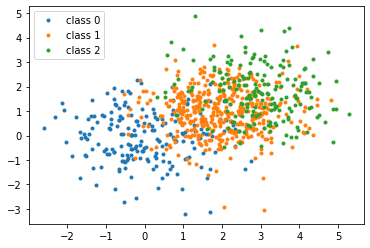

In [7]:
show(X_train, t_train)

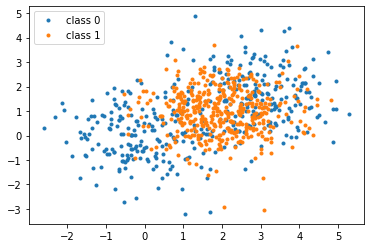

In [8]:
show(X_train, t2_train)

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

In [9]:
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1)

def mse(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += (y[i] - y_pred[i])**2
    mean_squared_error = sum_errors/len(y)
    return mean_squared_error

# Vector form solution
def msr2(x,y):
    return sum((x - y)**2) /x.shape[0]

class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)

class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.2, epochs=100, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        
        prev_mse = 10
        epoch = 0
        
        while True:
            theta -= gamma / k *  X_train.T @ (X_train @ theta - t_train)
            new_mse = mse(t_train, (X_train @ theta))
            if abs(prev_mse - new_mse) < diff or epoch > epochs:
                return
            else:
                prev_mse = new_mse
                epoch += 1
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.theta
        return score>threshold

In [10]:
for n in [1 / pow(10, m) for m in range(2, 11)]:
    lrc = NumpyLinRegClass()
    lrc.fit(X_train, t2_train, diff=n)
    print('Accuracy for diff = ', n, ':', lrc.accuracy(X_val, t2_val))

Accuracy for diff =  0.01 : 0.5125
Accuracy for diff =  0.001 : 0.545
Accuracy for diff =  0.0001 : 0.565
Accuracy for diff =  1e-05 : 0.5875
Accuracy for diff =  1e-06 : 0.6
Accuracy for diff =  1e-07 : 0.605
Accuracy for diff =  1e-08 : 0.6075
Accuracy for diff =  1e-09 : 0.6075
Accuracy for diff =  1e-10 : 0.6075


**ANSWER**

From this, we can see that the classifier plateaus at `diff = 1e-08`, so we choose that. Changing `gamma` from `0.1` to `0.2` gave a small improvement to the accuracy.

### Logistic regression
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [11]:
""" Implementation taken from the solution for exercises week 7 and adjusted to work with diff """
from math import log

def logistic(x):
    return 1/(1+np.exp(-x))

def cross_entropy_loss(target, predicted):
    """ Calculate Cross-Entropy Loss """
    # Solution inspired by https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
    r = 1
    sum_score = 0.0
    for t, p in zip(target, predicted):
        sum_score += t * log(0.0000000001 + abs(p))
    return -1.0 / len(target) * sum_score

class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.1, epochs=1000, diff=0.01):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        prev_cel = 10
        epoch = 0
        
        while True:
            theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train)
            new_cel = cross_entropy_loss(t_train, (X_train @ theta))
            if prev_cel - new_cel < diff or epoch > epochs:
                break
            else:
                prev_cel = new_cel
                epoch += 1
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        # score = z @ self.theta
        return (score>threshold).astype('int')

In [12]:
for n in [1 / pow(10, m) for m in range(11)]:
    lr = NumpyLogReg()
    lr.fit(X_train, t2_train, diff=n)
    print('Accuracy for n =', n, ':', lr.accuracy(X_val, t2_val))

Accuracy for n = 1.0 : 0.5875
Accuracy for n = 0.1 : 0.595
Accuracy for n = 0.01 : 0.5975
Accuracy for n = 0.001 : 0.605
Accuracy for n = 0.0001 : 0.605
Accuracy for n = 1e-05 : 0.605
Accuracy for n = 1e-06 : 0.605
Accuracy for n = 1e-07 : 0.605
Accuracy for n = 1e-08 : 0.605
Accuracy for n = 1e-09 : 0.605
Accuracy for n = 1e-10 : 0.605


**ANSWER**

As with the Linear Regression model, the classifier stops improving below some value for `diff`, this time the value being `0.001`. This time changing `gamma` in either directions gave no improvements to the accuracy.

### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You therefore have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X2_val, x2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

In [13]:
""" Implementation taken from exercises week 5, adjusted for our data structure """

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

class PyClassifier():
    """Common methods to all python classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
#         predicted = [self.predict(a, **kwargs) for a in X_test]
#         equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        
        pred_targ = np.array([[self.predict(a, **kwargs), t] for a, t in zip(X_test, y_test)])
        equal = sum([1 if p == t else 0 for p, t in pred_targ])
        return equal / len(y_test), pred_targ

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: self.k]]
        return majority(predictors)

In [14]:
""" I assume you mean 'test on (X_val, t2_val)' as neither X2_val, nor x2_val are defined in the precode """
for k in range(10, 21):
    knnC = PykNNClassifier(k=k)
    knnC.fit(X_train, t2_train)
    print('Accuracy for k =', k, ':', knnC.accuracy(X_val, t2_val)[0])

Accuracy for k = 10 : 0.74
Accuracy for k = 11 : 0.7375
Accuracy for k = 12 : 0.7525
Accuracy for k = 13 : 0.7475
Accuracy for k = 14 : 0.7675
Accuracy for k = 15 : 0.7525
Accuracy for k = 16 : 0.755
Accuracy for k = 17 : 0.75
Accuracy for k = 18 : 0.7575
Accuracy for k = 19 : 0.7525
Accuracy for k = 20 : 0.7625


**ANSWER**

We see that we have the highest accuracy for `k = 14`, so we choose this.

*The algorithm has been tested with a wider range of values for `k`, but it's been reduced for simplicity.*

### Simple perceptron
Finally, run the simple perceptron (week05) on the same set, and report and store accuracy.

In [15]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1, bias=1):
        """Train the self.weights on the training data eith learning
        rate eta, running epochs many epochs"""
        X_train = [[bias]+list(x) for x in X_train] # Put bias in position 0      
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0. There are better ways!

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] += eta * (t - y) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

In [16]:
for i in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 50, 75, 100, 150, 200, 300]:
    cl = PyPerClassifier()
    cl.fit(X_train, t2_train, eta= 0.1, epochs = i)
    test = cl.accuracy(X_val, t2_val)[0]
    print("Accuracy after {:2} epochs, test: {:6.3f}".format(i, test))

Accuracy after 10 epochs, test:  0.595
Accuracy after 11 epochs, test:  0.583
Accuracy after 12 epochs, test:  0.565
Accuracy after 13 epochs, test:  0.613
Accuracy after 14 epochs, test:  0.647
Accuracy after 15 epochs, test:  0.593
Accuracy after 16 epochs, test:  0.583
Accuracy after 17 epochs, test:  0.662
Accuracy after 18 epochs, test:  0.598
Accuracy after 19 epochs, test:  0.595
Accuracy after 20 epochs, test:  0.647
Accuracy after 25 epochs, test:  0.647
Accuracy after 30 epochs, test:  0.645
Accuracy after 50 epochs, test:  0.585
Accuracy after 75 epochs, test:  0.652
Accuracy after 100 epochs, test:  0.585
Accuracy after 150 epochs, test:  0.652
Accuracy after 200 epochs, test:  0.625
Accuracy after 300 epochs, test:  0.598


**ANSWER**

We see that `epochs = 17` gives the greatest accuracy score for our datasets, so we choose this.

*The algorithm has been tested with a wider range of values for `epoch` than <10, 20>, but we include this for illustrative purpose.*

### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

**ANSWER**

The following are results from our testing of binary classifiers:

| Algorithm | Optimal variable | Accuracy |
|-----------|------------------|----------|
| Linear Regression | `diff = 1e-08` | 0.6075 |
| Logistic Regresstion | `diff = 0.001` | 0.605 |
| k Nearest Neighbours | `k = 14` | 0.7675 |
| Simple Perceptron | `epochs = 17` | 0.662 |

We see that none of these classifiers are particularly good at predicting our non-linearly dividable binary dataset. The best we can do is the k-Nearest-Neighbours classifier, which manages just over 75% accuracy. Considering the distribution of our data set, this is expected.

## Multi-class classifiers
We now turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

In [17]:
for k in range(10, 31):
    knnC = PykNNClassifier(k=k)
    knnC.fit(X_train, t_train)
    print('Accuracy for k =', k, ':', knnC.accuracy(X_val, t_val)[0])

Accuracy for k = 10 : 0.745
Accuracy for k = 11 : 0.7475
Accuracy for k = 12 : 0.755
Accuracy for k = 13 : 0.75
Accuracy for k = 14 : 0.77
Accuracy for k = 15 : 0.7575
Accuracy for k = 16 : 0.76
Accuracy for k = 17 : 0.7525
Accuracy for k = 18 : 0.76
Accuracy for k = 19 : 0.755
Accuracy for k = 20 : 0.7675
Accuracy for k = 21 : 0.76
Accuracy for k = 22 : 0.765
Accuracy for k = 23 : 0.7525
Accuracy for k = 24 : 0.755
Accuracy for k = 25 : 0.7525
Accuracy for k = 26 : 0.7525
Accuracy for k = 27 : 0.75
Accuracy for k = 28 : 0.755
Accuracy for k = 29 : 0.755
Accuracy for k = 30 : 0.755


**ANSWER**

Again, `k = 14` gives the best result, an accuracy of 77% this time.

### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

In [18]:
""" We modify the original binary Logistic Regression class to return its confidence rather than the answer """

class MultiLogRegBase(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.1, epochs=1000, diff=0.01):
        """X_train is a kxm matrix, k data points, m features
        t_train are the target values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        prev_cel = 10
        epoch = 0
        
        while True:
            theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train)
            new_cel = cross_entropy_loss(t_train, (X_train @ theta))
            if prev_cel - new_cel < diff or epoch > epochs:
                break
            else:
                prev_cel = new_cel
                epoch += 1
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        return z @ self.theta

class MultiLogRegClass(NumpyClassifier):
    
    def __init__(self):
        self.classifiers = []
    
    def fit(self, X_train, t_train, gamma=0.2, epochs=1000, diff=0.1):
        """ Create one classifier for each class in t_train,
        train them individually using given parameters """
        
        classes = set(t_train)
        
        for c in classes:
            self.classifiers.append(MultiLogRegBase())
            self.classifiers[-1].fit(X_train, [1 if t == c else 0 for t in t_train], gamma=gamma, epochs=epochs, diff=diff)
    
    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append([])
            for c in self.classifiers:
                predictions[-1].append(c.predict(x))
        ret = np.array([x.index(max(x)) for x in predictions])
        return ret

In [19]:
for n in [5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001]:
    mlrc = MultiLogRegClass()
    mlrc.fit(X_train, t_train, diff=n)
    print('Accuracy for diff =', n, ':', mlrc.accuracy(X_val, t_val))

Accuracy for diff = 5 : 0.58
Accuracy for diff = 2 : 0.58
Accuracy for diff = 1 : 0.58
Accuracy for diff = 0.5 : 0.58
Accuracy for diff = 0.2 : 0.5825
Accuracy for diff = 0.1 : 0.5825
Accuracy for diff = 0.05 : 0.585
Accuracy for diff = 0.02 : 0.5875
Accuracy for diff = 0.01 : 0.59
Accuracy for diff = 0.005 : 0.595
Accuracy for diff = 0.002 : 0.6025
Accuracy for diff = 0.001 : 0.605
Accuracy for diff = 0.0005 : 0.605
Accuracy for diff = 0.0002 : 0.605
Accuracy for diff = 0.0001 : 0.605


Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

**ANSWER**

* The kNN classifier beats the Logistic Regression classifier by a significant margin, but none of them are particularly good.
* The results for the three-class classification task are very similar to the binary classification for the same classifiers.
* Because the data points are distributed somewhat along a line in the two dimensions, and Class 1 occupies most of the middle area, it is expected that a one-vs-rest logistic regression model would have a strong bias toward that class, to the detriment of the others. We see that it does not predict any of the data points belonging to Class 2, and very few to Class 0, this is expected considering the distribution of the three classes. The kNN classifier is inherently much better at predicting for this kind of distribution.

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g. on the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

In [20]:
""" Create a new dataset based on X and add the new features """

X_train2 = np.array([[x[0], x[1], x[0]*x[0], x[1]*x[1], x[0]*x[1]] for x in X_train])
X_val2 = np.array([[x[0], x[1], x[0]*x[0], x[1]*x[1], x[0]*x[1]] for x in X_val])

In [21]:
""" Test the Linear Classifier on the new dataset """
for diff in [1 / pow(10, m) for m in range(11)]:
    lrc = NumpyLinRegClass()
    lrc.fit(X_train2, t2_train, gamma=0.1, diff=diff)
    print('Accuracy for diff = ', diff, ':', lrc.accuracy(X_val2, t2_val))

Accuracy for diff =  1.0 : 0.5275
Accuracy for diff =  0.1 : 0.5275
Accuracy for diff =  0.01 : 0.5275
Accuracy for diff =  0.001 : 0.5275
Accuracy for diff =  0.0001 : 0.5275
Accuracy for diff =  1e-05 : 0.5275
Accuracy for diff =  1e-06 : 0.5275
Accuracy for diff =  1e-07 : 0.5275
Accuracy for diff =  1e-08 : 0.5275
Accuracy for diff =  1e-09 : 0.5275
Accuracy for diff =  1e-10 : 0.5275


In [22]:
""" Logistic Regression Classifier """
for diff in [1 / pow(10, m) for m in range(11)]:
    lr = NumpyLogReg()
    lr.fit(X_train2, t2_train, diff=diff)
    print('Accuracy for diff =', diff, ':', lr.accuracy(X_val2, t2_val))

Accuracy for diff = 1.0 : 0.615
Accuracy for diff = 0.1 : 0.6325
Accuracy for diff = 0.01 : 0.705
Accuracy for diff = 0.001 : 0.69
Accuracy for diff = 0.0001 : 0.69
Accuracy for diff = 1e-05 : 0.69
Accuracy for diff = 1e-06 : 0.69
Accuracy for diff = 1e-07 : 0.69
Accuracy for diff = 1e-08 : 0.69
Accuracy for diff = 1e-09 : 0.69
Accuracy for diff = 1e-10 : 0.69


In [23]:
""" k-Nearest-Neighbors Classifier """
for k in range(10, 21):
    knnC = PykNNClassifier(k=k)
    knnC.fit(X_train, t2_train)
    print('Accuracy for k =', k, ':', knnC.accuracy(X_val, t2_val)[0])

Accuracy for k = 10 : 0.74
Accuracy for k = 11 : 0.7375
Accuracy for k = 12 : 0.7525
Accuracy for k = 13 : 0.7475
Accuracy for k = 14 : 0.7675
Accuracy for k = 15 : 0.7525
Accuracy for k = 16 : 0.755
Accuracy for k = 17 : 0.75
Accuracy for k = 18 : 0.7575
Accuracy for k = 19 : 0.7525
Accuracy for k = 20 : 0.7625


In [24]:
""" Simple Perceptron Classifier """
for i in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 50, 75, 100, 150, 200, 300]:
    cl = PyPerClassifier()
    cl.fit(X_train2, t2_train, eta= 0.1, epochs = i)
    test = cl.accuracy(X_val2, t2_val)[0]
    print("Accuracy after {:2} epochs, test: {:6.3f}".format(i, test))

Accuracy after 10 epochs, test:  0.637
Accuracy after 11 epochs, test:  0.645
Accuracy after 12 epochs, test:  0.635
Accuracy after 13 epochs, test:  0.647
Accuracy after 14 epochs, test:  0.630
Accuracy after 15 epochs, test:  0.635
Accuracy after 16 epochs, test:  0.632
Accuracy after 17 epochs, test:  0.640
Accuracy after 18 epochs, test:  0.637
Accuracy after 19 epochs, test:  0.640
Accuracy after 20 epochs, test:  0.637
Accuracy after 25 epochs, test:  0.645
Accuracy after 30 epochs, test:  0.642
Accuracy after 50 epochs, test:  0.635
Accuracy after 75 epochs, test:  0.642
Accuracy after 100 epochs, test:  0.642
Accuracy after 150 epochs, test:  0.630
Accuracy after 200 epochs, test:  0.640
Accuracy after 300 epochs, test:  0.637


**ANSWER**

Table of best accuracy scores for each classifier for original dataset and with added non-linear features:

| Classifier | Original dataset | Non-linear features |
|---|---|---|
| Linear Regression | 0.6075 | 0.5275 |
| Logistic Regression | 0.605 | 0.705 |
| k-Nearest-Neighbors | 0.7675 | 0.7675 |
| Simple Perceptron | 0.662 | 0.647 |

We see that the Linear Regression classifier performs *worse* with the added non-linear features. Whether this is a natural consequence of the added features being *non-linear* or there is something wrong with my implementation is not obvious from the testing.

The Logistic Regression classifier improved somewhat. The Logistic Regression classifier should at least be able to handle non-linear features better than the Linear Regression classifier, so at least *some* improvement over it is expected.

The k-Nearest-Neighbors classifier saw no changes with the added features. This is also expected, as it operates based on the relative position between the data points, which remain unchanged when adding  new features based solely on already-existing features.

The Simple Perceptron saw very little change, though slightly for the worse overall. The Perceptron classifiers have a higher risk of overfitting with a higher number of features. Since our added features are based on already-existing ones, the impact is limited, but I believe we still see a higher amount of overfitting.

# Part II
## Multi-layer neural networks
We will now implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do it in two steps. In the first step, we will work concretely with the dataset (X, t). We will initailize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

In [25]:
# Your code
def scale(X, mins, maxs):
    r, d = X.shape
    ret = np.zeros((r, d))
    for dim in range(d):
        for row in range(r):
            ret[row][dim] = (X[row][dim] - mins[dim]) / (maxs[dim] - mins[dim])
    return ret

def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = - 1 * np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1)

# Take min/max values from each dimension of training set
mins = X_train.min(axis=0)
maxs = X_train.max(axis=0)

# Create scaled training and validation sets
X_train_scaled = scale(X_train, mins, maxs)
X_val_scaled = scale(X_val, mins, maxs)

# Convert target values from integers to vectors
t_train_vec = [[1 if i == t else 0 for i in range(len(set(t_train)))] for t in t_train]

## Step1: One round of training

### Intializing
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [26]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *y_train*. Beware that *y_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [27]:
dim_in = len(X_train[0])
dim_out = len(set(t_train))

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the 

output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [28]:
# Your code
V = np.random.rand(dim_in + 1, dim_hidden)
W = np.random.rand(dim_hidden + 1, dim_out)

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [29]:
# Your code
""" Repeat the logistic activation function """
def logistic(x):
    return 1/(1+np.exp(-x))

def activate(inputs, weights):
    return logistic(inputs @ weights)

hid_acts = add_bias(activate(add_bias(X_train_scaled), V))

In [30]:
# Your code
out_acts = activate(hid_acts, W)

**ANSWER**

These results seem very reasonable with respect to format and values. Unless I have misunderstood, there should be one set of activations of size equal to the number of inputs for the next layer for each input datapoint, thus `hidden_activations` should have shape `(800, 7)` and `output_activations` should have shape `(800, 3)`

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [31]:
# Your code
out_err = out_acts * (1 - out_acts) * (t_train_vec - out_acts)
print(out_err.shape)

(800, 3)


Calculate the error in the hidden layer.

In [32]:
# Your code
hid_err = hid_acts[:,1:] * (1 - hid_acts[:,1:]) * (out_err @ W[1:,:].T)
print(hid_err.shape)

(800, 6)


Update the weights.
Check that they have changed.

In [33]:
step_size = 0.01

print('Before updating')
print('V:\n', V)
print('W:\n', W)

new_V = V + step_size * (add_bias(X_train_scaled).T @ hid_err)
new_W = W + step_size * (hid_acts.T @ out_err)

print('\nAfter updating')
print('V:\n', new_V)
print('W:\n', new_W)

Before updating
V:
 [[0.84276507 0.82315282 0.71784748 0.32810878 0.03669763 0.500533  ]
 [0.54961402 0.79027548 0.39902267 0.45046081 0.39132326 0.88394184]
 [0.11880656 0.3304584  0.00485357 0.12995267 0.37099723 0.25852676]]
W:
 [[0.76445943 0.77236915 0.95393995]
 [0.81152695 0.08104003 0.08342925]
 [0.78808268 0.04953836 0.25482434]
 [0.32293121 0.15817464 0.56825474]
 [0.12959145 0.83379513 0.05746951]
 [0.23710711 0.75412461 0.32513606]
 [0.21494825 0.57490587 0.87203239]]

After updating
V:
 [[ 0.98387982  0.98873901  0.84921507  0.39706671  0.15337288  0.68508502]
 [ 0.46707303  0.69717563  0.333725    0.4150413   0.33334844  0.79757131]
 [ 0.02300478  0.22368823 -0.06511291  0.09554037  0.31197719  0.17063481]]
W:
 [[ 1.41751346  0.96398195  1.51807053]
 [ 0.55383709  0.00985362 -0.12202672]
 [ 0.48012675 -0.03185637  0.02083409]
 [ 0.07244352  0.08679591  0.3612447 ]
 [-0.20265435  0.74075128 -0.21326697]
 [-0.16366793  0.64413323  0.00266136]
 [-0.14644091  0.47767151  0.59

##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [62]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

        # Should you put additional code here?
        
    def fit(self, X_train, t_train, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs."""
        
        # Initilaization
        self.dim_in = len(X_train[0])
        if type(t_train[0]) is not np.ndarray:
            # t_train is not vectorized
            self.dim_out =  len(set(t_train))
            t_train = [[1 if i == t else 0 for i in range(self.dim_out)] for t in t_train]
        else:
            self.dim_out = len(t_train[0])
        
        self.V = np.random.rand(self.dim_in + 1, self.dim_hidden)
        self.W = np.random.rand(self.dim_hidden + 1, self.dim_out)
        
        for e in range(epochs):
            # Feed forward and get activations
            hid_acts, out_acts = self.forward(X_train)
            
            # Calculate errors
            out_err = out_acts * (1 - out_acts) * (t_train - out_acts)
            hid_err = hid_acts[:,1:] * (1 - hid_acts[:,1:]) * (out_err @ self.W[1:,:].T)

            # Update weights
            self.V = self.V + self.eta * (add_bias(X_train).T @ hid_err)
            self.W = self.W + self.eta * (hid_acts.T @ out_err)

    def add_bias(self, X):
        # Put bias in position 0
        sh = X.shape
        if len(sh) == 1:
            #X is a vector
            return np.concatenate([np.array([1]), X])
        else:
            # X is a matrix
            m = sh[0]
            bias = -1 * np.ones((m,1)) # Makes a m*1 matrix of 1-s
            return np.concatenate([bias, X], axis  = 1)
    
    def logistic(self, x):
        return 1/(1+np.exp(-x))
    
    def activate(self, inputs, weights):
        return self.logistic(inputs @ weights)
    
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hid_acts = self.add_bias(self.activate(add_bias(X), self.V))
        return hid_acts, self.activate(hid_acts, self.W)

    def accuracy(self, X_test, t_test):
        """Calculate the accuracy of the classifier on the pair (X_test, t_test)
        Return the accuracy"""
        preds = np.array([np.argmax(p) for p in self.forward(X_test)[1]])
        correct = 0
        for p, t in zip(preds, t_test):
            correct += 1 if p == t else 0
        return correct / len(preds), np.column_stack((preds, t_test))

**COMMENT**

*I could not figure out the proper numpy matrix operations to perform the weight updates in time for the deadline. The way it's currently done is extremely slow and puts practical limits on the hyperparameters that I'm not completely satisfied with. I would have wanted to train it using a lower learning rate and a much higher number of epochs, but it would take far too long to train with these parameters.*

*I'll catch up on Numpy matrix operations before next assignment, but any feedback as to what went wrong in my implementation this time is appreciated.*

Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [63]:
mnn = MNNClassifier(eta=0.001)
# Find min/max values of training set
mins = X_train.min(axis=0)
maxs = X_train.max(axis=0)

mnn.fit(scale(X_train, mins, maxs), t_train, epochs=5000)
print(mnn.accuracy(scale(X_val, mins, maxs), t_val)[0])

0.755


# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

In [64]:
def print_confusion_matrix(res, num_classes):
    print('Confusion matrix:')
    matrix = np.zeros((num_classes, num_classes))
    for r in res:
        matrix[r[0]][r[1]] += 1
    print(matrix)

def print_precision_recall(res, num_classes):
    precision = [0.0] * num_classes
    recall = [0.0] * num_classes
    for c in range(num_classes):
        true_pos = 0
        false_neg = 0
        false_pos = 0
        for row in res:
            if row[0] == c:
                if row[1] == c:
                    true_pos += 1
                else:
                    false_pos += 1
            else:
                if row[1] == c:
                    false_neg += 1
        precision[c] = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0.0
        recall[c] = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0.0
    print('\nPrecision:')
    for c in range(num_classes):
        print('Class', c, precision[c])
    print('\nRecall:')
    for c in range(num_classes):
        print('Class', c, recall[c])
    print()

print('------ Multi-class classifiers ------')

num_classes = len(set(t_test))

print('--- k-Nearest-Neighbors ---')
knn = PykNNClassifier(k=14)
knn.fit(X_train, t_train)
knn_accuracy, knn_res = knn.accuracy(X_test, t_test)
print('Accuracy :', knn_accuracy)
print_confusion_matrix(knn_res, num_classes)
print_precision_recall(knn_res, num_classes)

print('--- Multi-Layer Perceptron ---')
mlp = MNNClassifier(eta=0.001)
mins = X_train.min(axis=0)
maxs = X_train.max(axis=0)
mnn.fit(scale(X_train, mins, maxs), t_train, epochs=5000)
mnn_accuracy, mnn_res = mnn.accuracy(scale(X_test, mins, maxs), t_test)
print('Accuracy :', mnn_accuracy)
print_confusion_matrix(mnn_res, num_classes)
print_precision_recall(mnn_res, num_classes)

print('------ Binary Classifiers ------')
print('--- k-Nearest-Neighbors ---')
knn = PykNNClassifier(k=14)
knn.fit(X_train, t2_train)
knn_accuracy, knn_res = knn.accuracy(X_test, t2_test)
print('Accuracy :', knn_accuracy)
print_confusion_matrix(knn_res, 2)
print_precision_recall(knn_res, 2)

------ Multi-class classifiers ------
--- k-Nearest-Neighbors ---
Accuracy : 0.7475
Confusion matrix:
[[ 69.  10.   0.]
 [ 23. 159.  42.]
 [  0.  26.  71.]]

Precision:
Class 0 0.8734177215189873
Class 1 0.7098214285714286
Class 2 0.7319587628865979

Recall:
Class 0 0.75
Class 1 0.8153846153846154
Class 2 0.6283185840707964

--- Multi-Layer Perceptron ---
Accuracy : 0.7525
Confusion matrix:
[[ 70.   8.   0.]
 [ 22. 166.  48.]
 [  0.  21.  65.]]

Precision:
Class 0 0.8974358974358975
Class 1 0.7033898305084746
Class 2 0.7558139534883721

Recall:
Class 0 0.7608695652173914
Class 1 0.8512820512820513
Class 2 0.5752212389380531

------ Binary Classifiers ------
--- k-Nearest-Neighbors ---
Accuracy : 0.75
Confusion matrix:
[[141.  36.]
 [ 64. 159.]]

Precision:
Class 0 0.7966101694915254
Class 1 0.7130044843049327

Recall:
Class 0 0.6878048780487804
Class 1 0.8153846153846154



**COMMENT**

*I have included two classifiers for the multi-class part. This is because I suspect a proper implementation of the MLP classifier would perform better than the kNN classifier, but since I do not have a proper implementation of it I also included the classifier that actually performed best.*

*In terms of the classifiers' performance on the test set vs on the validation set, they are very similar. This is because none of the classifiers actually do anything that could cause them to fit their learning to the validation set.*